# Objetivo:
> Clasificación de una muestra de galaxias AGN en galaxias con núcleos activos de alta excitación (HERG) y de baja excitación (LERG). Esto es, crear un algoritmo que utilice muestras de galaxias ya clasificadas en HERGs y LERGs como muestras de entrenamiento y luego aplicarlo en la identificación de galaxias clasificadas como AGNs.
## Muestras:
> Se dispone de una muestra de galaxias clasificadas como galaxias AGN, una muestra de galaxias AGN clasificadas como galaxias de tipo HERG y otra muestra de galaxias AGN clasificadas como galaxias de tipo LERG. Las tres muestras pertenecen a la muestra principial del survey Sloan (SDSS).
## Features de las muestras
> Para cada galaxia se tiene 24 features: 
- Redshift espectroscópico 
- Error en redshift 
- Masa estelar
- Caraterística espectral Dn4000
- El flujo para cuatro líneas espectrales y sus correspondientes errores
- Magnitud absoluta en los cinco filtros del Sloan
- Colores
- Magnitudes w1 y w2 del survey Wise y sus correspondientes errores

In [1]:
from astropy.table import Table
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
sns.set()

# Lectura de datos

In [2]:
AGNs = Table.read('AGNs_noClass.fits')
AGNs = AGNs.to_pandas()
AGNs.columns

Index(['SFIRST', 'Z', 'Z_ERR', 'SMASS_MEDIAN', 'D4000', 'O3F', 'N2F', 'HBF',
       'HAF', 'O3F_ERR', 'N2F_ERR', 'HBF_ERR', 'HAF_ERR', 'O3HB', 'N2HA',
       'O3HB_ERR', 'MODELR', 'MODELRERR', 'PETROR', 'PETRORERR', 'ABSU',
       'ABSG', 'ABSR', 'ABSI', 'ABSZ', 'w1mpro', 'w1sigmpro', 'w2mpro',
       'w2sigmpro'],
      dtype='object')

In [3]:
HERGs = Table.read('HERGs.fits')
HERGs = HERGs.to_pandas()
LERGs = Table.read('LERGs.fits')
LERGs = LERGs.to_pandas()

In [4]:
AGNs['g-r'] = AGNs['ABSG'] - AGNs['ABSR']
AGNs['u-r'] = AGNs['ABSU'] - AGNs['ABSU']
HERGs['g-r'] = HERGs['ABSG'] - HERGs['ABSR']
HERGs['u-r'] = HERGs['ABSU'] - HERGs['ABSR']
LERGs['g-r'] = LERGs['ABSG'] - LERGs['ABSR']
LERGs['u-r'] = LERGs['ABSU'] - LERGs['ABSR']

# Análisis exploratorio

En este análisis se limita la información de algunas columnas al rango determinado por los cuartiles 0.01 y 0.99, con la intención de que las representaciones gráficas reflejen sólo la parte más significativa de los datos. Esto sólo se realiza en esta etapa exploratoria, en el entrenamiento del algoritmo se pretende utilizar todos los datos.

Se averigua la cantidad de valores nan, a la vez que la cantidad de valores de mediciones sin sentido físico.

In [5]:
# Valores nan en cada columna
print(np.sum(LERGs.isnull(), axis=0))
# Valores negativos en cada columna
np.sum(LERGs < 0, axis=0)

SFIRST          107
Z                 0
Z_ERR             0
SMASS_MEDIAN      0
D4000             0
O3F               0
N2F               0
HBF               0
HAF               0
O3F_ERR           0
N2F_ERR           0
HBF_ERR           0
HAF_ERR           0
O3HB              0
N2HA              0
O3HB_ERR          0
MODELR            0
MODELRERR         0
PETROR            0
PETRORERR         0
ABSU              0
ABSG              0
ABSR              0
ABSI              0
ABSZ              0
w1mpro           12
w1sigmpro        14
w2mpro           12
w2sigmpro        12
g-r               0
u-r               0
dtype: int64


SFIRST             0
Z                  0
Z_ERR              0
SMASS_MEDIAN      29
D4000              0
O3F                0
N2F                0
HBF                0
HAF                0
O3F_ERR            0
N2F_ERR            0
HBF_ERR            0
HAF_ERR            0
O3HB             537
N2HA             838
O3HB_ERR           0
MODELR             0
MODELRERR          0
PETROR             0
PETRORERR          0
ABSU            1682
ABSG            1682
ABSR            1682
ABSI            1682
ABSZ            1682
w1mpro             0
w1sigmpro          0
w2mpro             0
w2sigmpro          0
g-r                0
u-r                0
dtype: int64

In [6]:
# Valores nan en cada columna
print(np.sum(HERGs.isnull(), axis=0))
# Valores negativos en cada columna
np.sum(HERGs < 0, axis=0)

SFIRST          26
Z                0
Z_ERR            0
SMASS_MEDIAN     0
D4000            0
O3F              0
N2F              0
HBF              0
HAF              0
O3F_ERR          0
N2F_ERR          0
HBF_ERR          0
HAF_ERR          0
O3HB             0
N2HA             0
O3HB_ERR         0
MODELR           0
MODELRERR        0
PETROR           0
PETRORERR        0
ABSU             0
ABSG             0
ABSR             0
ABSI             0
ABSZ             0
w1mpro           2
w1sigmpro        2
w2mpro           2
w2sigmpro        2
g-r              0
u-r              0
dtype: int64


SFIRST            0
Z                 0
Z_ERR             0
SMASS_MEDIAN      1
D4000             0
O3F               0
N2F               0
HBF               0
HAF               0
O3F_ERR           0
N2F_ERR           0
HBF_ERR           0
HAF_ERR           0
O3HB              0
N2HA            103
O3HB_ERR          0
MODELR            0
MODELRERR         0
PETROR            0
PETRORERR         0
ABSU            173
ABSG            173
ABSR            173
ABSI            173
ABSZ            173
w1mpro            0
w1sigmpro         0
w2mpro            0
w2sigmpro         0
g-r               0
u-r               0
dtype: int64

In [7]:
# Valores nan en cada columna
print(np.sum(AGNs.isnull(), axis=0))
# Valores negativos en cada columna
np.sum(AGNs < 0, axis=0)

SFIRST           97
Z                 0
Z_ERR             0
SMASS_MEDIAN      0
D4000             0
O3F               0
N2F               0
HBF               0
HAF               0
O3F_ERR           0
N2F_ERR           0
HBF_ERR           0
HAF_ERR           0
O3HB            231
N2HA            272
O3HB_ERR         14
MODELR            0
MODELRERR         0
PETROR            0
PETRORERR         0
ABSU              0
ABSG              0
ABSR              0
ABSI              0
ABSZ              0
w1mpro            7
w1sigmpro         7
w2mpro            7
w2sigmpro         7
g-r               0
u-r               0
dtype: int64


SFIRST             0
Z                  0
Z_ERR              0
SMASS_MEDIAN      15
D4000              0
O3F               63
N2F               82
HBF              193
HAF              185
O3F_ERR            8
N2F_ERR           13
HBF_ERR            0
HAF_ERR           13
O3HB             203
N2HA             287
O3HB_ERR         225
MODELR             0
MODELRERR          0
PETROR             0
PETRORERR          0
ABSU            1078
ABSG            1078
ABSR            1078
ABSI            1078
ABSZ            1078
w1mpro             0
w1sigmpro          0
w2mpro             0
w2sigmpro          0
g-r                0
u-r                0
dtype: int64

Se eliminan las filas que poseen algún valor "nan" en alguna de sus columnas.

In [8]:
AGNs = AGNs.dropna()
HERGs = HERGs.dropna()
LERGs = LERGs.dropna()
print('HERGs = ', len(HERGs))
print('LERGs = ', len(LERGs))
print('AGNs = ', len(AGNs))

HERGs =  145
LERGs =  1561
AGNs =  590


Se eliminan aquellas filas que poseen valores negativos en propiedades que deben ser sólo valores positivos.

In [9]:
LERGs = LERGs[LERGs['SMASS_MEDIAN'] > 0]
LERGs = LERGs[LERGs['O3F'] > 0]
LERGs = LERGs[LERGs['N2F'] > 0]
LERGs = LERGs[LERGs['HBF'] > 0]
LERGs = LERGs[LERGs['HAF'] > 0]
LERGs = LERGs[LERGs['O3F_ERR'] > 0]
LERGs = LERGs[LERGs['N2F_ERR'] > 0]
LERGs = LERGs[LERGs['HBF_ERR'] > 0]
LERGs = LERGs[LERGs['HAF_ERR'] > 0]
LERGs = LERGs[LERGs['O3HB'] > 0]
LERGs = LERGs[LERGs['N2HA'] > 0]
HERGs = HERGs[HERGs['SMASS_MEDIAN'] > 0]
HERGs = HERGs[HERGs['O3F'] > 0]
HERGs = HERGs[HERGs['N2F'] > 0]
HERGs = HERGs[HERGs['HBF'] > 0]
HERGs = HERGs[HERGs['HAF'] > 0]
HERGs = HERGs[HERGs['O3F_ERR'] > 0]
HERGs = HERGs[HERGs['N2F_ERR'] > 0]
HERGs = HERGs[HERGs['HBF_ERR'] > 0]
HERGs = HERGs[HERGs['HAF_ERR'] > 0]
HERGs = HERGs[HERGs['O3HB'] > 0]
HERGs = HERGs[HERGs['N2HA'] > 0]
HERGs = HERGs[HERGs['w1mpro'] > 0]
HERGs = HERGs[HERGs['w1sigmpro'] > 0]
HERGs = HERGs[HERGs['w2mpro'] > 0]
HERGs = HERGs[HERGs['w2sigmpro'] > 0]
AGNs = AGNs[AGNs['SMASS_MEDIAN'] > 0]
AGNs = AGNs[AGNs['O3F'] > 0]
AGNs = AGNs[AGNs['N2F'] > 0]
AGNs = AGNs[AGNs['HBF'] > 0]
AGNs = AGNs[AGNs['HAF'] > 0]
AGNs = AGNs[AGNs['O3F_ERR'] > 0]
AGNs = AGNs[AGNs['N2F_ERR'] > 0]
AGNs = AGNs[AGNs['HBF_ERR'] > 0]
AGNs = AGNs[AGNs['HAF_ERR'] > 0]
AGNs = AGNs[AGNs['O3HB'] > 0]
AGNs = AGNs[AGNs['N2HA'] > 0]
AGNs = AGNs[AGNs['w1mpro'] > 0]
AGNs = AGNs[AGNs['w1sigmpro'] > 0]
AGNs = AGNs[AGNs['w2mpro'] > 0]
AGNs = AGNs[AGNs['w2sigmpro'] > 0]
print('HERGs = ', len(HERGs))
print('LERGs = ', len(LERGs))
print('AGNs = ', len(AGNs))

HERGs =  65
LERGs =  637
AGNs =  288


Se unen los datos en una sola tabla para facilitar su visualización gráfica.

In [14]:
fulldata = pd.concat([HERGs.assign(dataset='HERG'), LERGs.assign(dataset='LERG'), AGNs.assign(dataset='AGN')])
fulldata = fulldata.reset_index()
print('HERGs = ', np.sum((fulldata['dataset'] == 'HERG')))
print('LERGs = ', np.sum((fulldata['dataset'] == 'LERG')))
print('AGN = ', np.sum((fulldata['dataset'] == 'AGN')))
fulldata.describe()

HERGs =  65
LERGs =  637
AGN =  288


,index,SFIRST,Z,Z_ERR,SMASS_MEDIAN,D4000,O3F,N2F,HBF,HAF,...,ABSG,ABSR,ABSI,ABSZ,w1mpro,w1sigmpro,w2mpro,w2sigmpro,g-r,u-r
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,708.565657,29.459282,0.145637,0.000028,11.320766,1.866837,68.015236,119.685295,22.704525,85.286369,...,-21.165325,-21.968164,-22.341568,-22.659447,13.412882,0.026715,13.174687,0.030853,0.802833,1.849326
std,471.133319,81.250214,0.059167,0.000013,0.264447,0.154730,197.381714,189.398499,32.328480,139.095093,...,0.632997,0.633858,0.633143,0.631823,0.630337,0.007194,0.597087,0.006393,0.062564,1.210406
min,0.000000,0.800000,0.030168,0.000008,9.907578,1.171277,1.310142,2.335993,0.001901,0.026776,...,-22.829987,-23.678017,-24.038025,-24.344231,10.845000,0.022000,9.653000,0.020000,0.440981,0.000000
25%,302.500000,5.000000,0.095369,0.000018,11.173808,1.814892,16.235028,28.724940,7.984583,14.923837,...,-21.597948,-22.395112,-22.765021,-23.078694,12.958000,0.024000,12.786500,0.026000,0.780325,0.000000
50%,675.000000,8.200000,0.139973,0.000025,11.340262,1.903214,30.925505,68.213593,15.574833,50.867430,...,-21.218540,-22.021749,-22.397960,-22.714538,13.528500,0.025000,13.268000,0.030000,0.803095,2.525409
75%,1040.000000,19.375000,0.189557,0.000035,11.489040,1.966788,54.751334,131.089653,26.721594,95.246323,...,-20.820406,-21.600097,-21.963315,-22.288829,13.904750,0.027000,13.614750,0.034000,0.827274,2.698009
max,1680.000000,1044.699951,0.299181,0.000127,12.020122,2.192048,4717.699219,2829.305908,488.348969,1942.183960,...,-18.085480,-18.666733,-19.098026,-19.296665,14.659000,0.119000,14.371000,0.059000,1.364037,6.388499


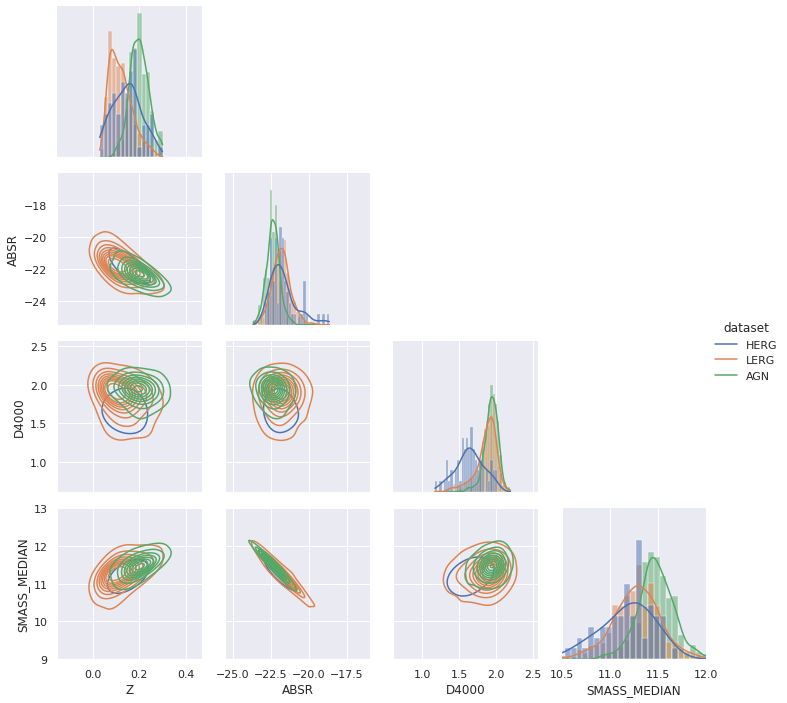

In [11]:
g = sns.PairGrid(fulldata, vars=['Z','ABSR','D4000','SMASS_MEDIAN'], hue='dataset', corner=True)
g.map_lower(sns.kdeplot, bw_adjust=2)
g.map_diag(sns.histplot, stat="probability", common_norm=False, kde=True)
g.axes[3,1].set(ylim=(9,13))
g.axes[3,2].set(ylim=(9,13))
g.axes[3,3].set(ylim=(9,13))
g.axes[3,3].set(xlim=(10.5,12))
g.add_legend()

## *Diagrama BPT*

(-1.0, 2.5)

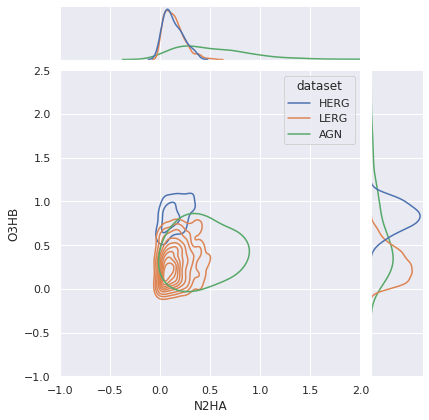

In [12]:
g = sns.jointplot(data=fulldata, x="N2HA", y="O3HB", kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
g.ax_marg_x.set_xlim(-1, 2)
g.ax_marg_y.set_ylim(-1, 2.5)

## *Diagrama de color*

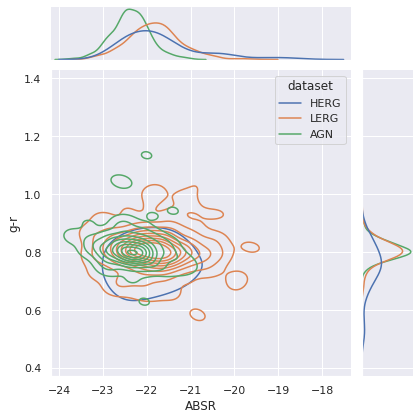

In [13]:
sns.jointplot(data=fulldata, x="ABSR", y='g-r', kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
#g.ax_marg_x.set_xlim(-19.5, -23.5)
#g.ax_marg_y.set_ylim(0.4, 1.1)

## *Análisis PCA*

In [15]:
# Se normalizan los datos
ss = StandardScaler()
fulldata = fulldata.drop('dataset', axis=1)
datanorm = ss.fit_transform(fulldata)

In [16]:
pca = PCA()
pca.fit(datanorm)
comp = pca.transform(datanorm)
mean = pca.mean_
components = pca.components_
var = pca.explained_variance_ratio_
var = np.cumsum(var)

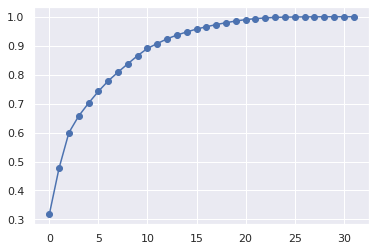

In [18]:
plt.plot(var, marker='o')

# Training

#### Elección del modelo

In [19]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

#### Precisión del modelo

In [20]:
classsample = pd.concat([HERGs.assign(AGN_Tipe='HERG'), LERGs.assign(AGN_Tipe='LERG')])
le = LabelEncoder()
classsample = classsample.apply(le.fit_transform)

In [21]:
ind_vars = classsample.drop(['AGN_Tipe'], axis=1)
dep_vars = classsample['AGN_Tipe']

In [22]:
from sklearn.model_selection import cross_validate
scores = np.zeros(10)
for i, score in enumerate(cross_validate(model, ind_vars, dep_vars, cv=10)["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")
    scores[i] = score
print('Precisión promedio: ', scores.mean())
print('Desvío estándar: ', scores.std())

Accuracy for the fold no. 0 on the test set: 0.9436619718309859
Accuracy for the fold no. 1 on the test set: 0.9859154929577465
Accuracy for the fold no. 2 on the test set: 0.9714285714285714
Accuracy for the fold no. 3 on the test set: 0.9857142857142858
Accuracy for the fold no. 4 on the test set: 0.9857142857142858
Accuracy for the fold no. 5 on the test set: 0.9857142857142858
Accuracy for the fold no. 6 on the test set: 0.9428571428571428
Accuracy for the fold no. 7 on the test set: 0.9714285714285714
Accuracy for the fold no. 8 on the test set: 0.9714285714285714
Accuracy for the fold no. 9 on the test set: 0.9571428571428572
Precisión promedio:  0.9701006036217305
Desvío estándar:  0.01611171320769317


#### Muestra de training y test

In [23]:
ind_vars_train, ind_vars_test, dep_vars_train, dep_vars_test = train_test_split(ind_vars, dep_vars, shuffle=True, stratify=dep_vars)
print('Cantidad de LERGs en la muestra de entrenamiento: ', np.sum(dep_vars_train == 1))
print('Cantidad de HERGs en la muestra de entrenamiento: ', np.sum(dep_vars_train == 0))
print('Cantidad de LERGs en la muestra de testeo: ', np.sum(dep_vars_test == 1))
print('Cantidad de HERGs en la muestra de testeo: ', np.sum(dep_vars_test == 0))
print('Distribución de clases en entrenamiento')
print(dep_vars_train.value_counts(normalize=True))
print('Distribución de clases en testeo')
print(dep_vars_test.value_counts(normalize=True))

Cantidad de LERGs en la muestra de entrenamiento:  477
Cantidad de HERGs en la muestra de entrenamiento:  49
Cantidad de LERGs en la muestra de testeo:  160
Cantidad de HERGs en la muestra de testeo:  16
Distribución de clases en entrenamiento
1    0.906844
0    0.093156
Name: AGN_Tipe, dtype: float64
Distribución de clases en testeo
1    0.909091
0    0.090909
Name: AGN_Tipe, dtype: float64


In [25]:
ind_vars_train

,SFIRST,Z,Z_ERR,SMASS_MEDIAN,D4000,O3F,N2F,HBF,HAF,O3F_ERR,...,ABSG,ABSR,ABSI,ABSZ,w1mpro,w1sigmpro,w2mpro,w2sigmpro,g-r,u-r
1240,360,460,56,392,35,679,644,678,655,631,...,199,238,254,257,137,1,24,3,43,13
394,174,395,208,453,385,441,474,576,506,300,...,270,263,263,272,302,14,336,20,469,345
355,217,658,571,251,43,453,659,390,546,442,...,118,165,210,203,525,3,493,10,16,91
971,78,132,68,158,246,508,456,570,494,274,...,513,531,534,543,205,2,222,6,177,231
376,25,386,401,433,288,158,99,294,135,113,...,301,293,294,282,328,2,341,7,373,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,205,301,505,592,50,201,200,420,295,312,...,84,83,84,81,145,1,129,2,155,104
138,237,665,324,112,7,626,344,366,394,156,...,67,127,242,256,557,4,378,8,5,10
1385,358,298,136,528,48,584,671,585,651,616,...,173,184,181,166,94,1,88,2,167,98
88,167,645,594,504,303,335,413,379,467,57,...,240,220,193,192,536,4,527,14,583,311


#### Entrenamiento y testeo

In [13]:
model_fit = model.fit(ind_vars_train, dep_vars_train)
#model_pred = model_fit.predict(ind_vars_test)
model_pred = (model_fit.predict_proba(ind_vars_test)[:, 1] > 0.81).astype('float')
print("Precisión del algoritmo: ", (accuracy_score(model_pred, dep_vars_test)*100))
print()
print('Matriz de confusión')
print(pd.DataFrame(confusion_matrix(dep_vars_test, model_pred),columns=['pred_0', 'pred_1']))

Precisión del algoritmo:  96.85393258426967

Matriz de confusión
   pred_0  pred_1
0      22       2
1      12     409


#### Ajuste del threshold

ROC function:

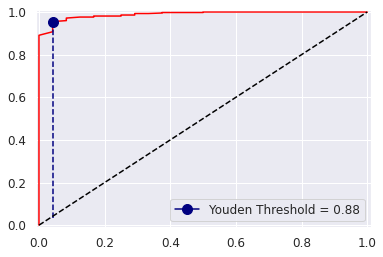

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
model_pred_p = model_fit.predict_proba(ind_vars_test)[:, 1]
FPR, TPR, Thresholds = roc_curve(dep_vars_test, model_pred_p)
auc = roc_auc_score(dep_vars_test, model_pred_p)
youden_idx = np.argmax(np.abs(TPR - FPR))
youden_threshold = Thresholds[youden_idx]
y_pred_youden = (model_pred_p > youden_threshold).astype(int)

plt.plot(FPR, TPR, color = "red")
plt.plot(FPR[youden_idx], TPR[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
plt.axvline(x = FPR[youden_idx], ymin = FPR[youden_idx], ymax = TPR[youden_idx], color = "navy", ls = "--")
plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)

# Clasificación de AGNs

In [17]:
model_pred = (model.predict_proba(AGNs)[:, 1] > 0.88).astype(int)
print(model_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [20]:
print(model.predict_proba(AGNs))

[[0.21 0.79]
 [0.22 0.78]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.22 0.78]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]
 [0.21 0.79]

## Visualización de la clasificación

In [19]:
newLERGs = AGNs[model_pred == 1]
len(newLERGs)

0

In [56]:
newHERGs = AGNs[model_pred == 0]
len(newHERGs)

0

### Comparación entre la muestra de LERGs y las AGNs clasificadas como LERGs por medio del algoritmo.

In [57]:
fulldataLERG = pd.concat([LERGs.assign(dataset='LERG'), newLERGs.assign(dataset='newLERGs')])
fulldataLERG = fulldataLERG.reset_index()

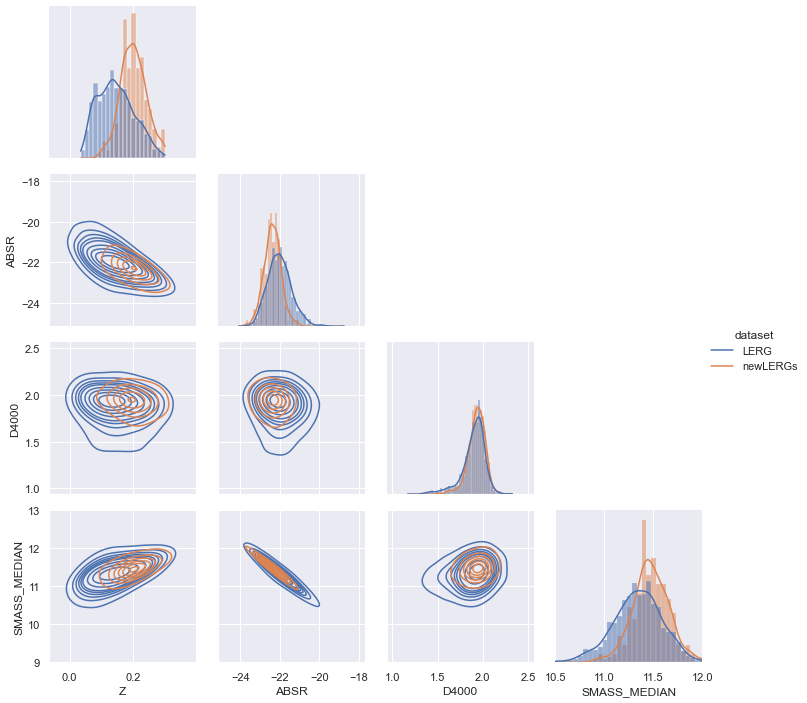

In [60]:
g = sns.PairGrid(fulldataLERG, vars=['Z','ABSR','D4000','SMASS_MEDIAN'], hue='dataset', corner=True)
g.map_lower(sns.kdeplot, bw_adjust=2)
g.map_diag(sns.histplot, stat="probability", common_norm=False, kde=True)
g.axes[3,1].set(ylim=(9,13))
g.axes[3,2].set(ylim=(9,13))
g.axes[3,3].set(ylim=(9,13))
g.axes[3,3].set(xlim=(10.5,12))
g.add_legend()

(-1.0, 2.5)

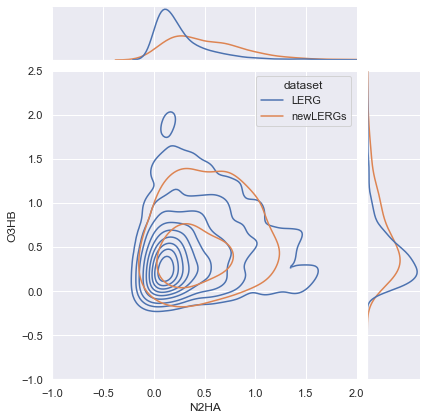

In [62]:
g = sns.jointplot(data=fulldataLERG, x="N2HA", y="O3HB", kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
g.ax_marg_x.set_xlim(-1, 2)
g.ax_marg_y.set_ylim(-1, 2.5)

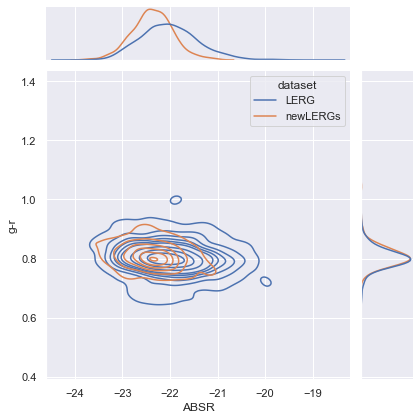

In [68]:
sns.jointplot(data=fulldataLERG, x="ABSR", y='g-r', kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))

### Comparación entre la muestra de HERGs y las AGNs clasificadas como HERGs por medio del algoritmo.

In [65]:
fulldataHERG = pd.concat([HERGs.assign(dataset='HERG'), newHERGs.assign(dataset='newHERGs')])
fulldataHERG = fulldataHERG.reset_index()

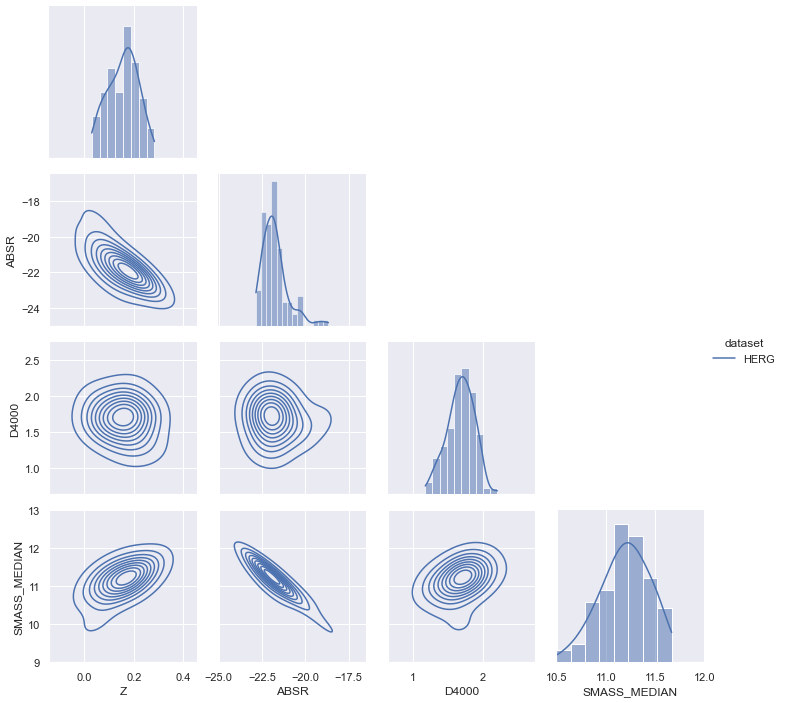

In [66]:
g = sns.PairGrid(fulldataHERG, vars=['Z','ABSR','D4000','SMASS_MEDIAN'], hue='dataset', corner=True)
g.map_lower(sns.kdeplot, bw_adjust=2)
g.map_diag(sns.histplot, stat="probability", common_norm=False, kde=True)
g.axes[3,1].set(ylim=(9,13))
g.axes[3,2].set(ylim=(9,13))
g.axes[3,3].set(ylim=(9,13))
g.axes[3,3].set(xlim=(10.5,12))
g.add_legend()

(-1.0, 2.5)

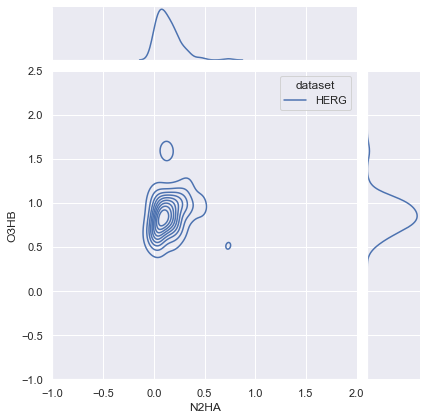

In [67]:
g = sns.jointplot(data=fulldataHERG, x="N2HA", y="O3HB", kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
g.ax_marg_x.set_xlim(-1, 2)
g.ax_marg_y.set_ylim(-1, 2.5)

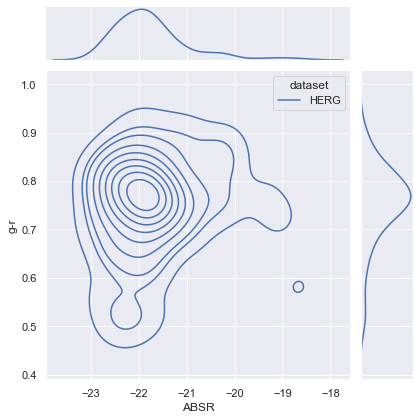

In [69]:
sns.jointplot(data=fulldataHERG, x="ABSR", y='g-r', kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))